# Produce Cached `galaxy_ids` for DC2

_Last Updated: Bryce Kalmbach, December 2018_

This is a notebook to produce the cached AGN and SN galaxy_id lists for DC2 Run 2. In this notebook we match the source AGN and SNe galaxies to objects in the galaxy catalogs.

In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
from desc.sims.GCRCatSimInterface import InstanceCatalogWriter
from lsst.sims.utils import SpecMap
import matplotlib.pyplot as plt
from lsst.utils import getPackageDir
from lsst.sims.photUtils import Sed, BandpassDict, Bandpass
from lsst.sims.catUtils.matchSED import matchBase
import os
import sqlite3
%matplotlib inline

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/global/homes/b/brycek/DC2/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:555: UserWarning: Duplicate object type id 4 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/global/homes/b/brycek/DC2/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:555: UserWarning: Duplicate object type id 28 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


## Point to locations for unlensed AGN and SNe information

Even if you already have an unsprinkled instance catalog ready you need to specify the locations of DC2 unlensed AGN and SNe databases. The AGN database is needed to know the AGN properties to sprinkle and the SNe database is needed to avoid sprinkling with galaxies that will have unlensed SNe at some point in the survey.

In [2]:
catalog_version = 'cosmoDC2_v1.1.4'
agnDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/agn_db_mbh7_mi30_sf4.db'
sneDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sne_cosmoDC2_v1.1.4_MS_DDF.db'
sed_lookup_dir = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sedLookup'

### Create an unsprinkled Instance Catalog 

This is to get the possible AGN and Bulge galaxies to replace with the sprinkler. We use `cosmoDC2_v1.1.4_image_addon_knots`. Make sure to specify the correct database locations in the cell below.

In [3]:
# First we need to create a catalog without sprinkling
opsimDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/minion_1016_desc_dithered_v4.db'
starDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/dc2_stellar_db.db'

In [4]:
t_sky = InstanceCatalogWriter(opsimDB, '%s_image_addon_knots' % catalog_version, min_mag=30, protoDC2_ra=0,
                              protoDC2_dec=0, sprinkler=False,
                              agn_db_name=agnDB, star_db_name=starDB,
                              sed_lookup_dir=sed_lookup_dir)

In [ ]:
uddf_visit = 197356 # Use a visit we know covers the uDDF field
t_sky.write_catalog(uddf_visit, out_dir='.', fov=2.1)

### Load in the galaxy catalogs as dataframes

In [4]:
base_columns = ['prefix', 'uniqueId', 'raPhoSim', 'decPhoSim',
                        'phosimMagNorm', 'sedFilepath', 'redshift',
                        'shear1', 'shear2', 'kappa', 'raOffset', 'decOffset',
                        'spatialmodel']

In [5]:
df_galaxy = pd.read_csv(os.path.join(os.environ['SCRATCH'],
                                     'bulge_gal_cat_197356.txt.gz'),
                                delimiter=' ', header=None,
                                names=base_columns+['majorAxis', 'minorAxis',
                                                    'positionAngle', 'sindex',
                                                    'internalExtinctionModel',
                                                    'internalAv', 'internalRv',
                                                    'galacticExtinctionModel',
                                                    'galacticAv', 'galacticRv'])

In [6]:
df_disk = pd.read_csv(os.path.join(os.environ['SCRATCH'],
                                     'disk_gal_cat_197356.txt.gz'),
                                delimiter=' ', header=None,
                                names=base_columns+['majorAxis', 'minorAxis',
                                                    'positionAngle', 'sindex',
                                                    'internalExtinctionModel',
                                                    'internalAv', 'internalRv',
                                                    'galacticExtinctionModel',
                                                    'galacticAv', 'galacticRv'])

In [7]:
df_agn = pd.read_csv(os.path.join(os.environ['SCRATCH'],
                                     'agn_gal_cat_197356.txt.gz'),
                                 delimiter=' ', header=None,
                                 names=base_columns+['internalExtinctionModel',
                                                     'galacticExtinctionModel',
                                                     'galacticAv', 'galacticRv'])

We calculate the `galaxy_id` for each catalog so that we can join them together and also save it in the cache for the sprinkler.

In [8]:
df_agn['galaxy_id'] = np.right_shift(df_agn['uniqueId'], 10)

In [9]:
df_agn.head()

,prefix,uniqueId,raPhoSim,decPhoSim,phosimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,raOffset,decOffset,spatialmodel,internalExtinctionModel,galacticExtinctionModel,galacticAv,galacticRv,galaxy_id
0,object,3392000069749,54.351016,-29.474949,21.245477,agnSED/agn.spec.gz,0.047309,-0.000002,-0.000048,0.000007,0,0,point,none,CCM,0.029307,3.1,3312500068
1,object,3392000201845,55.064013,-29.107730,19.310657,agnSED/agn.spec.gz,0.027914,-0.000015,0.000021,-0.000026,0,0,point,none,CCM,0.045022,3.1,3312500197
2,object,3392000248949,54.820543,-29.341426,20.232832,agnSED/agn.spec.gz,0.044629,-0.000012,0.000021,-0.000017,0,0,point,none,CCM,0.036800,3.1,3312500243
3,object,3392000249973,54.847392,-29.342723,22.711512,agnSED/agn.spec.gz,0.044629,-0.000008,0.000030,-0.000014,0,0,point,none,CCM,0.038021,3.1,3312500244
4,object,3392000252021,54.772554,-29.279037,23.265985,agnSED/agn.spec.gz,0.044629,-0.000055,0.000038,0.000025,0,0,point,none,CCM,0.035074,3.1,3312500246


In [10]:
df_galaxy['galaxy_id'] = np.right_shift(df_galaxy['uniqueId'], 10)

In [11]:
df_galaxy.head()

,prefix,uniqueId,raPhoSim,decPhoSim,phosimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,...,minorAxis,positionAngle,sindex,internalExtinctionModel,internalAv,internalRv,galacticExtinctionModel,galacticAv,galacticRv,galaxy_id
0,object,3392000025697,54.881856,-28.765553,21.346167,galaxySED/Burst.80E09.002Z.spec.gz,0.017818,-0.000000,-0.000000,0.000000,...,0.648529,80.872978,4,CCM,0.0,2.0,CCM,0.044331,3.1,3312500025
1,object,3392000033889,54.815604,-28.803041,22.967427,galaxySED/Exp.80E09.002Z.spec.gz,0.021390,-0.000000,-0.000000,0.000000,...,0.298480,88.921657,4,CCM,0.0,2.0,CCM,0.044144,3.1,3312500033
2,object,3392000037985,55.234418,-29.034768,23.699069,galaxySED/Exp.10E10.002Z.spec.gz,0.018474,-0.000000,-0.000000,0.000000,...,1.166655,129.902200,4,CCM,0.0,2.0,CCM,0.047380,3.1,3312500037
3,object,3392000069729,54.351016,-29.474949,15.274427,galaxySED/Exp.10E10.04Z.spec.gz,0.047309,-0.000002,-0.000048,0.000007,...,2.746652,58.996228,4,CCM,0.0,2.0,CCM,0.029307,3.1,3312500068
4,object,3392000070753,54.913149,-29.205063,21.510131,galaxySED/Burst.80E09.04Z.spec.gz,0.037030,-0.000018,0.000027,-0.000017,...,0.708551,129.172123,4,CCM,0.0,2.0,CCM,0.039536,3.1,3312500069


In [12]:
df_disk['galaxy_id'] = np.right_shift(df_disk['uniqueId'], 10)

In [13]:
df_disk.head()

,prefix,uniqueId,raPhoSim,decPhoSim,phosimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,...,minorAxis,positionAngle,sindex,internalExtinctionModel,internalAv,internalRv,galacticExtinctionModel,galacticAv,galacticRv,galaxy_id
0,object,3392000009323,54.693652,-29.077189,18.192925,galaxySED/Exp.20E09.02Z.spec.gz,0.020022,-0.0,-0.0,0.0,...,2.121733,3.872094,1,CCM,0.1,4.0,CCM,0.041432,3.1,3312500009
1,object,3392000016491,54.877503,-28.839979,20.971618,galaxySED/Burst.20E09.0005Z.spec.gz,0.018648,-0.0,-0.0,0.0,...,2.155571,79.758104,1,CCM,0.1,3.5,CCM,0.046292,3.1,3312500016
2,object,3392000019563,54.994210,-28.802359,22.405348,galaxySED/Exp.50E09.0005Z.spec.gz,0.017085,-0.0,-0.0,0.0,...,0.557445,157.899908,1,CCM,0.2,2.1,CCM,0.045183,3.1,3312500019
3,object,3392000022635,54.562747,-29.058309,23.121197,galaxySED/Exp.50E09.002Z.spec.gz,0.020561,-0.0,-0.0,0.0,...,1.082256,93.739670,1,CCM,0.1,2.8,CCM,0.034288,3.1,3312500022
4,object,3392000025707,54.881856,-28.765553,23.794633,galaxySED/Exp.62E09.0005Z.spec.gz,0.017818,-0.0,-0.0,0.0,...,0.794547,80.872978,1,CCM,0.1,2.9,CCM,0.044331,3.1,3312500025


### Match the AGN catalog to Twinkles systems

We will go through the AGN catalog and find AGN in the uDDF field that match our properties. We will then save the `galaxy_id` of these AGN and give the corresponding OM10 system a `twinklesId` in the catalog that identifies it with this AGN when the sprinkler runs.

In [14]:
# Load in OM10 lenses we are using in Twinkles

from astropy.io import fits
hdulist = fits.open('../../data/twinkles_lenses_%s.fits' % catalog_version)
twinkles_lenses = hdulist[1].data

In [15]:
# Only search within the DDF field
df_agn = df_agn.query('raPhoSim < 53.755 and raPhoSim > 52.495 and decPhoSim < -27.55 and decPhoSim > -28.65')
df_galaxy = df_galaxy.query('raPhoSim < 53.755 and raPhoSim > 52.495 and decPhoSim < -27.55 and decPhoSim > -28.65')
df_disk = df_disk.query('raPhoSim < 53.755 and raPhoSim > 52.495 and decPhoSim < -27.55 and decPhoSim > -28.65')

In [16]:
df_agn = df_agn.reset_index(drop=True)
df_galaxy = df_galaxy.reset_index(drop=True)
df_disk = df_disk.reset_index(drop=True)

In [17]:
# Convert phosimMagNorm to i-band magnitudes for the uDDF AGN
bpDict = BandpassDict.loadTotalBandpassesFromFiles(bandpassNames=['i'])
bp = Bandpass()
imsimBand = bp.imsimBandpass()
agn_fname = str(getPackageDir('sims_sed_library') + '/agnSED/agn.spec.gz')

src_iband = []
src_mag_norm = df_agn['phosimMagNorm'].values
src_z = df_agn['redshift'].values

for src_mag, s_z in zip(src_mag_norm, src_z):
    agn_sed = Sed()
    agn_sed.readSED_flambda(agn_fname)
    agn_sed.redshiftSED(s_z, dimming=True)
    f_norm = agn_sed.calcFluxNorm(src_mag, bp)
    agn_sed.multiplyFluxNorm(f_norm)
    src_iband.append(agn_sed.calcMag(bpDict['i']))

In [18]:
df_agn['i_magnitude'] = src_iband

We want to match the AGN in the uDDF field to lensed systems based upon the redshift and magnitude of the source AGN. In this example we use 0.1 dex in redshift and 0.25 mags in the _i_-band. **(Anytime you use a new catalog this may need to be played with to get the desired number of systems)**

In [19]:
def find_agn_lens_candidates(galz, gal_mag):
        # search the OM10 catalog for all sources +- 0.1 dex in redshift                                                                                               
        # and within .25 mags of the AGN source                                                                                                                     
    w = np.where((np.abs(np.log10(twinkles_lenses['ZSRC']) - np.log10(galz)) <= 0.1) &
                     (np.abs(twinkles_lenses['MAGI_IN'] - gal_mag) <= .25))[0]
    lens_candidates = twinkles_lenses[w]

    return lens_candidates

#### Avoid galaxies with unlensed SNe.

First load up cached `galaxy_ids` and then to speed things up when comparing to possible sprinkled ids we use database merges to only find the ones that are in the uddf field.

In [20]:
conn = sqlite3.connect(sneDB) 

In [21]:
sne_query = conn.cursor()

In [22]:
sne_unsprinkled_galids = sne_query.execute('select galaxy_id from sne_params').fetchall()

In [23]:
sne_unsprinkled_galids = np.array(sne_unsprinkled_galids).flatten()

In [24]:
ddf_galids = pd.DataFrame(df_agn['galaxy_id'])

In [25]:
ddf_galids = ddf_galids.merge(pd.DataFrame(df_galaxy['galaxy_id']), how='outer', on='galaxy_id')

In [26]:
ddf_galids = ddf_galids.merge(pd.DataFrame(df_disk['galaxy_id']), how='outer', on='galaxy_id')

In [27]:
sne_avoid_galids = ddf_galids.merge(pd.DataFrame(sne_unsprinkled_galids, columns=['galaxy_id']), how='inner', on='galaxy_id')

In [28]:
sne_avoid_galids = sne_avoid_galids.values

#### Add weights to get final sprinkled distribution close to OM10

In [29]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

In [30]:
n, bins = np.histogram(twinkles_lenses['MAGI_IN'], bins=20)

In [31]:
bin_centers = 0.5*(bins[:-1] + bins[1:])
n = n / np.max(n)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


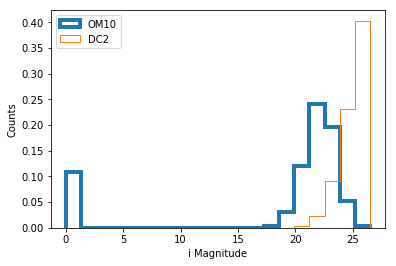

In [32]:
mpl.rcParams['text.usetex'] = False
n, bins, _ = plt.hist(twinkles_lenses['MAGI_IN'][np.where(twinkles_lenses['ZSRC'] <= (3. + np.log10(3.)*.1))],
                      histtype='step', lw=4, normed=True, bins=20, label='OM10')
plt.hist(df_agn['i_magnitude'].values, bins=bins, histtype='step', normed=True, label='DC2')
plt.xlabel('i Magnitude')
plt.ylabel('Counts')
plt.legend(loc=2)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


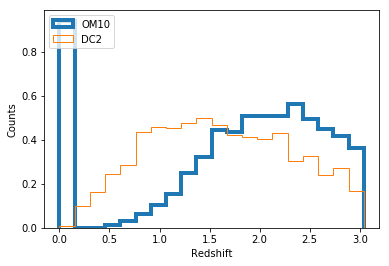

In [33]:
mpl.rcParams['text.usetex'] = False
n_z, bins_z, _ = plt.hist(twinkles_lenses['ZSRC'][np.where(twinkles_lenses['ZSRC'] <= (3. + np.log10(3.)*.1))],
                          histtype='step', lw=4, normed=True, bins=20, label='OM10')
plt.hist(df_agn['redshift'].values, bins=bins_z, histtype='step', normed=True, label='DC2')
plt.xlabel('Redshift')
plt.ylabel('Counts')
plt.legend(loc=2)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


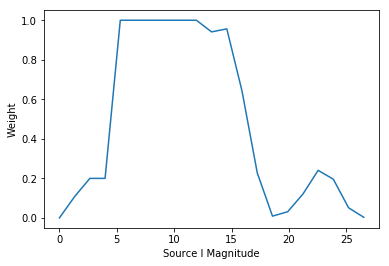

In [34]:
n_zeros = np.zeros(22)
n_zeros[1:-1] = n

n_2 = np.zeros(22)
n_2 += n_zeros
n_2[2:-6] += 2. * n_zeros[8:]
n_2[9] += 0.1
n_2[10] += 0.2
n_2[11] += 0.1
#n_2[6:15] += 2. * (2. - np.linspace(0, 2, 9))
n_2[6:15] += 1. * (1. - np.linspace(0, 1, 9))
#n_2[6:11] += 2. * (2. - np.linspace(0, 2, 5))
n_2 = n_2 / np.max(n_2)
n_2[2:4] += .2
n_2[4:10] = 1.0

plt.plot(bins, n_2[:-1])
plt.xlabel('Source I Magnitude')
plt.ylabel('Weight')

-0.00592244418331


/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


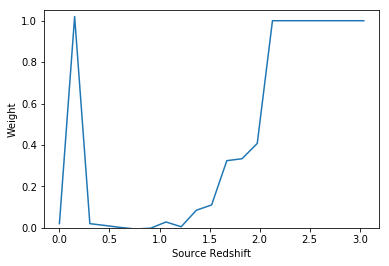

In [35]:
n_redshift = np.zeros(22)
n_redshift[1:-1] = n_z
n_redshift = n_redshift / np.max(n_redshift)
n_redshift[:8] += 0.1
n_redshift[-8:] = 1.0
n_redshift[:-8] -= 0.08
n_redshift[5:-8] -= 0.05
n_redshift[3] -= 0.01
n_redshift[4] -= 0.03
n_redshift[5] -= 0.01
n_redshift[6] -= 0.04
n_redshift[7] -= 0.05
n_redshift[8] -= 0.03
n_redshift[9] -=0.05
n_redshift[10] -= 0.1
n_redshift[11] -= 0.02
#n_redshift[12] -= 0.
#n_redshift = n_reds
print(np.min(n_redshift))

plt.plot(bins_z, n_redshift[:-1])
plt.ylim(0, 1.05)
plt.xlabel('Source Redshift')
plt.ylabel('Weight')

#### Sprinkle in the AGN

In [36]:
%%time
density_param = 1.0
good_rows = []
ra_list = []
dec_list = []
gal_ids = []
catalog_row_num = []
catalog_ids = []

for row_idx in range(len(df_agn)):
    
    row = df_agn.iloc[row_idx]
    
    if row_idx % 5000 == 0:
        print(row_idx, len(catalog_ids))

    if row.galaxy_id > 0:
        candidates = find_agn_lens_candidates(row.redshift, row.i_magnitude)
        np.random.seed(np.int(row.galaxy_id) % 4294967296)
        keep_idx = []
        if len(candidates) > 0:
            for candidate_idx, candidate_sys in list(enumerate(candidates['LENSID'])):
                if candidate_sys not in catalog_ids:
                    keep_idx.append(candidate_idx)
            if len(keep_idx) == 0:
                continue
            else:
                candidates = candidates[keep_idx]
        pick_value = np.random.uniform()
        
        bin_num = np.digitize(row['i_magnitude'], bins)
        binz_num = np.digitize(row['redshift'], bins_z)

        #density_param_mag = n_zeros[bin_num] * density_param
        density_param_mag = n_2[bin_num] * n_redshift[binz_num] * density_param
        
        if ((len(candidates) > 0) and (pick_value <= density_param_mag)):
            good_rows.append(row_idx)
            gal_ids.append(row.galaxy_id)
            newlens = np.random.choice(candidates)
            catalog_ids.append(newlens['LENSID'])
            catalog_row_num.append(np.where(twinkles_lenses['LENSID'] == newlens['LENSID'])[0][0])
            ra_list.append(row.raPhoSim)
            dec_list.append(row.decPhoSim)
            #print(len(catalog_ids))

0 0


/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


5000 1
10000 1
15000 4
20000 6
25000 9
30000 19
35000 50
40000 79
45000 140
50000 223
55000 303
60000 392
65000 477
70000 480
75000 526
CPU times: user 18min 21s, sys: 6.75 s, total: 18min 28s
Wall time: 18min 28s


#### Check performance of weights

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


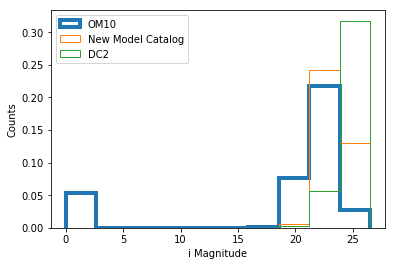

In [37]:
mpl.rcParams['text.usetex'] = False
n, bins, _ = plt.hist(twinkles_lenses['MAGI_IN'][np.where(twinkles_lenses['ZSRC'] <= (3. + np.log10(3.)*.1))],
                      histtype='step', lw=4, normed=True, bins=10, label='OM10')
plt.hist(df_agn['i_magnitude'].values[good_rows], normed=True, bins=bins, histtype='step', label='New Model Catalog')
plt.hist(df_agn['i_magnitude'].values, bins=bins, histtype='step', normed=True, label='DC2')
plt.xlabel('i Magnitude')
plt.ylabel('Counts')
plt.legend(loc=2)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


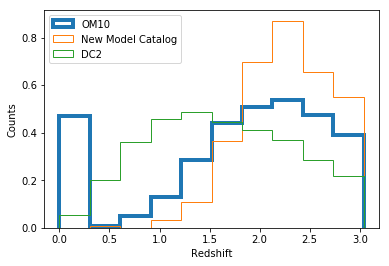

In [38]:
mpl.rcParams['text.usetex'] = False
n_z, bins_z, _ = plt.hist(twinkles_lenses['ZSRC'][np.where(twinkles_lenses['ZSRC'] <= (3. + np.log10(3.)*.1))],
                          histtype='step', lw=4, normed=True, bins=10, label='OM10')
plt.hist(df_agn['redshift'].values[good_rows], normed=True, bins=bins_z, histtype='step', label='New Model Catalog')
plt.hist(df_agn['redshift'].values, bins=bins_z, histtype='step', normed=True, label='DC2')
plt.xlabel('Redshift')
plt.ylabel('Counts')
plt.legend(loc=2)

In [39]:
print(len(catalog_ids))

574


In [40]:
len(good_rows), len(np.unique(good_rows)), len(np.unique(catalog_ids)), len(np.unique(catalog_row_num))

(574, 574, 574, 574)

Check to see that our cached systems are distributed throughout the uDDF field.

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


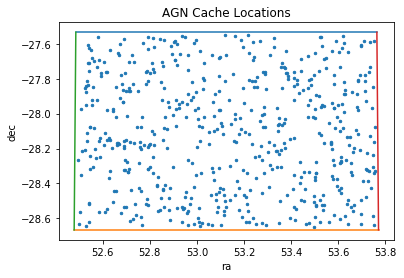

In [41]:
plt.scatter(ra_list, dec_list, s=6)
plt.plot((52.486, 53.764), (-27.533, -27.533))
plt.plot((52.479, 53.771), (-28.667, -28.667))
plt.plot((52.479, 52.486), (-28.667, -27.533))
plt.plot((53.771, 53.764), (-28.667, -27.533))
plt.xlabel(r'ra')
plt.ylabel(r'dec')
plt.title('AGN Cache Locations')
#plt.savefig('agn_cache.png')

In [42]:
catalog_row_sort = np.argsort(catalog_row_num)
catalog_row_num = np.array(catalog_row_num)

In [43]:
# Add in Twinkles ID Number to catalog for matched objects
col_list = []
for col in twinkles_lenses.columns:
        col_list.append(fits.Column(name=col.name, format=col.format, array=twinkles_lenses[col.name][catalog_row_num[catalog_row_sort]]))
col_list.append(fits.Column(name='twinklesId', format='I', array=np.arange(len(good_rows))))

Save this catalog of only the systems we need.

In [45]:
cols = fits.ColDefs(col_list)
tbhdu = fits.BinTableHDU.from_columns(cols)
tbhdu.writeto('../../data/%s_matched_AGN.fits' % catalog_version)

In [46]:
tbhdu.data[:5]

FITS_rec([ ( 147709, 0, 2,  0.138,  200.9093,  0.1228137,  141.6722 ,  0.07074275,  -99.27816,  2.23,  0.2850695 ,  0.336907  ,  22.67,  22.45241,  2.13716 , [-0.4212,  0.7536,  0.    ,  0.    ], [-0.4333,  1.352 ,  0.    ,  0.    ], [-1.2219,  3.2226,  0.    ,  0.    ], [ 16.602,   0.   ,   0.   ,   0.   ], [ 0.,  0.,  0.,  0.], [ 0.,  0.,  0.,  0.],  502.80249 ,   651.151367, -22.2036209,  17.0027885,  0.138     ,  1701.2 ,  1524.06,  0.,  17748.4,  0.,  2.24242353,  0., 'galaxySED/Exp.10E10.04Z.spec.gz', [ 18.24878128,  18.16570995,  18.11535194,  18.10778929,  18.13078826,  18.05590982],  0.1,  4., 0),
          ( 644983, 0, 4,  0.23 ,  218.273 ,  0.2395391,   75.76444,  0.07699725,  122.8281 ,  3.26,  0.05766959,  0.03962186,  24.67,  22.99666,  2.527611, [ 0.5019, -1.0162,  1.1623,  0.0601], [-1.179 , -0.1809, -0.0727,  1.3097], [ 5.7046, -3.0928, -5.2005,  4.6702], [  2.262,   8.18 ,   4.272,   0.   ], [ 0.,  0.,  0.,  0.], [ 0.,  0.,  0.,  0.],  757.855042,  1146.55896 , -22.49

Save the cached `galaxy_id` info to file

In [47]:
agn_cache = pd.DataFrame(np.array([np.array(gal_ids)[catalog_row_sort], np.arange(len(good_rows))], dtype=np.int).T,
                         columns=['galtileid', 'twinkles_system'])

In [48]:
agn_cache.head()

,galtileid,twinkles_system
0,1890392355,0
1,1894528332,1
2,2581151729,2
3,2582033153,3
4,2568941434,4


In [49]:
agn_cache.tail()

,galtileid,twinkles_system
569,2570374544,569
570,2569837038,570
571,2582699550,571
572,2568937817,572
573,2575564948,573


In [50]:
#Check that galaxy_ids and twinkles_ids in FITS match up after sort
g_id = np.where(np.array(gal_ids) == agn_cache['galtileid'].values[0])
print(np.array(catalog_ids)[g_id] == tbhdu.data['LENSID'][0])

[ True]


In [52]:
agn_cache.to_csv('../../data/%s_agn_cache.csv' % catalog_version, index=False)

### Match to GLSNe catalog

Here we do the same as we did for the AGN and OM10 catalog except with a bulge+disk galaxy catalog and the host galaxy information from the Gravitationally Lensed SNe catalog.

We begin by loading the hdf5 tables for the lensed SNe catalog into dataframes.

In [14]:
sne_systems = pd.read_hdf('/global/cscratch1/sd/brycek/glsne_%s.h5' % catalog_version, key='system')
sne_images = pd.read_hdf('/global/cscratch1/sd/brycek/glsne_%s.h5' % catalog_version, key='image')

In [15]:
use_gals_df = df_galaxy.query('raPhoSim > 52.495 and raPhoSim < 53.755 and decPhoSim > -28.65 and decPhoSim < -27.55')

In [16]:
len(use_gals_df)

1799129

In [17]:
use_gals_df = use_gals_df.merge(df_disk, on='galaxy_id', suffixes=('_bulge', '_disk'))

Following from Table 3 in Mannucci et al. 2005 (https://www.aanda.org/articles/aa/pdf/2005/15/aa1411.pdf) we are going to use galaxy colors
to scale the sn rate by color as a proxy for galaxy type, but we end up changing it from that a bit to give us good sample sizes of all types in the DDF region.

In [18]:
from lsst.utils import getPackageDir

In [19]:
sims_sed_list = os.listdir(os.path.join(getPackageDir('SIMS_SED_LIBRARY'),
                                        'galaxySED'))

In [20]:
sims_sed_dict = {}
for sed_name in sims_sed_list:
    sed_obj = Sed()
    sed_obj.readSED_flambda(os.path.join(getPackageDir('SIMS_SED_LIBRARY'),
                                         'galaxySED', sed_name))
    sims_sed_dict[os.path.join('galaxySED', sed_name)] = sed_obj

In [21]:
# Filters from http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php
bp_B = Bandpass(wavelen_max = 2700.)
bp_B.setBandpass(wavelen=np.array([360., 380., 400., 420., 460., 480.,
                                   500., 520., 540., 560.]),
                 sb=np.array([0.00, 0.11, 0.92, 0.94, 0.79, 0.58,
                              0.36, 0.15, 0.04, 0.0]))
bp_K = Bandpass(wavelen_max = 2700.)
bp_K.setBandpass(wavelen=np.linspace(1800., 2600., 17),
                 sb=np.array([0.00, 0.10, 0.48, 0.95, 1.00, 0.98,
                              0.96, 0.95, 0.97, 0.96, 0.94, 0.95,
                              0.95, 0.84, 0.46, 0.08, 0.00]))
bp_dict = BandpassDict(bandpassNameList=['B', 'K'], bandpassList=[bp_B, bp_K])

In [ ]:
from lsst.sims.photUtils import getImsimFluxNorm
from copy import deepcopy
bk_color = []
i = 0
for sed_name_bulge, redshift, magNorm_bulge, sed_name_disk, magNorm_disk in zip(use_gals_df['sedFilepath_bulge'].values,
                                                                                use_gals_df['redshift_bulge'].values,
                                                                                use_gals_df['phosimMagNorm_bulge'].values,
                                                                                use_gals_df['sedFilepath_disk'].values,
                                                                                use_gals_df['phosimMagNorm_disk'].values):
    if i % 100000 == 0:
        print(i)

    sed_obj_bulge = deepcopy(sims_sed_dict[sed_name_bulge])
    f_norm_b = getImsimFluxNorm(sed_obj_bulge, magNorm_bulge)
    sed_obj_bulge.multiplyFluxNorm(f_norm_b)
    sed_obj_bulge.redshiftSED(redshift)
    
    sed_obj_disk = deepcopy(sims_sed_dict[sed_name_disk])
    f_norm_d = getImsimFluxNorm(sed_obj_disk, magNorm_disk)
    sed_obj_disk.multiplyFluxNorm(f_norm_d)
    sed_obj_disk.redshiftSED(redshift)
    
    sed_obj = Sed()
    sed_obj.setSED(wavelen=sed_obj_bulge.wavelen, flambda=sed_obj_bulge.flambda+sed_obj_disk.flambda)
    
    
    b_val, k_val = bp_dict.magListForSed(sed_obj)
    bk_color.append(b_val - k_val)
    i+=1

In [ ]:
bk_color = np.array(bk_color)

In [ ]:
# Save so if kernel resets we don't have to do it again.
np.savetxt('bk_color.dat', bk_color)

In [22]:
# Uncomment to load from file
#bk_color = np.genfromtxt('bk_color.dat')

In [23]:
use_gals_df['bk_color'] = bk_color

In [24]:
use_gals_df = use_gals_df.reset_index(drop=True)

As we did before we match based upon a property in each catalog. Here we use the source redshift of the SNe in the lens catalog and the redshift of the potential host galaxies in the uDDF field. Since we have so many potential host galaxies we tighten up the redshift bounds to 0.01 in dex. We also use the galaxy type from the colors to associate to proper types of host galaxies in the lensed SNe catalog.

In [25]:
def find_sne_lens_candidates(galz, gal_type):#, gal_mag):
    # search the galaxy catalog for all possible host galaxies +- 0.05 dex in redshift

    lens_candidates = sne_systems.query(str('zs < {}'.format(np.power(10, np.log10(galz)+0.01)) + ' and ' +
                                            'zs > {}'.format(np.power(10, np.log10(galz)-0.01))))
        
    if gal_type == 't1':
        lens_candidates = lens_candidates.query('host_type == "kinney-starburst"')
    elif gal_type == 't4':
        lens_candidates = lens_candidates.query('host_type == "kinney-elliptical"')
    else:
        lens_candidates = lens_candidates.query('host_type == "kinney-sc"')

    return lens_candidates

In [36]:
#%%time
density_param = .0006
good_rows_sn = []
gal_ids_sn = []
sys_ids_sn = []
used_systems = []
ra_list_sn = []
dec_list_sn = []
type_sn = []
redshift_sn = []

rd_state = np.random.RandomState(47)

for row_idx in range(len(use_gals_df)):
    
    density_test = rd_state.uniform()
    
    gal_bk = use_gals_df['bk_color'].iloc[row_idx]
    
    if gal_bk < 2.6:
        type_density_param = 1.2*density_param
        gal_type = 't1'
    elif ((2.6 <= gal_bk) and (gal_bk < 3.3)):
        type_density_param = 3.*density_param
        gal_type = 't2'
    elif ((3.3 <= gal_bk) and (gal_bk < 4.1)):
        type_density_param = 2.*density_param
        gal_type = 't3'
    else:
        type_density_param = 3.*density_param
        gal_type = 't4'
    
    if density_test > type_density_param:
        continue
    
    row = use_gals_df.iloc[row_idx]
    
    gal_id = use_gals_df['galaxy_id'].iloc[row_idx]
    if gal_id in df_agn['galaxy_id'].values:
        continue
    elif gal_id in sne_avoid_galids:
        continue
    
    if len(good_rows_sn) % 50 == 0:
        print(row_idx, len(good_rows_sn))

    if row.galaxy_id > 0:
        #print(gal_type)
        candidates = find_sne_lens_candidates(row.redshift_bulge, gal_type)
        #print(len(candidates))
        np.random.seed(np.int(row.galaxy_id) % 4294967296)
        keep_idx = []
        for candidate_idx in range(len(candidates)):
            if candidates.index[candidate_idx] in used_systems:
                continue
            else:
                keep_idx.append(candidate_idx)
        candidates = candidates.iloc[keep_idx]

        if len(candidates) > 0:
            choice = np.random.choice(np.arange(len(candidates)), p=candidates['weight']/np.sum(candidates['weight']))
            used_systems.append(candidates.index[choice])
            newlens = candidates.iloc[choice]
            #print(len(catalog_ids))
            sys_ids_sn.append(newlens.sysno)
            gal_ids_sn.append(row.galaxy_id)
            ra_list_sn.append(row.raPhoSim_bulge)
            dec_list_sn.append(row.decPhoSim_bulge)
            good_rows_sn.append(row_idx)
            type_sn.append(gal_type)
            redshift_sn.append(row.redshift_bulge)

271 0
58475 50
114990 100
158482 150
209430 200
273460 250
339681 300
404020 350
450681 400
506795 450
572161 500
634838 550
690250 600
771999 650
835457 700
912207 750
982165 800
1060549 850
1551077 900
1605673 950
1662697 1000


In [37]:
len(good_rows_sn), len(ra_list_sn)

(1024, 1024)

In [38]:
print(len(np.where(np.array(type_sn) == "t1")[0]))
print(len(np.where(np.array(type_sn) == "t2")[0]))
print(len(np.where(np.array(type_sn) == "t3")[0]))
print(len(np.where(np.array(type_sn) == "t4")[0]))

672
175
100
77


Once again check to see that we are spread throught uDDF region.

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


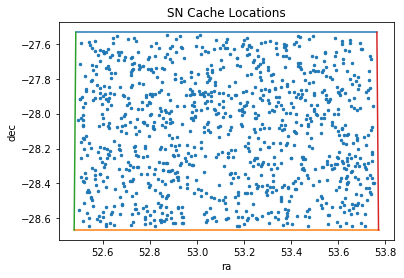

In [42]:
plt.scatter(ra_list_sn, dec_list_sn, s=6)
plt.plot((52.486, 53.764), (-27.533, -27.533))
plt.plot((52.479, 53.771), (-28.667, -28.667))
plt.plot((52.479, 52.486), (-28.667, -27.533))
plt.plot((53.771, 53.764), (-28.667, -27.533))
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('SN Cache Locations')
#plt.savefig('sne_cache.png')

Now we need to join the information in the systems and image dataframes and then save only the ones we are using to file.

In [43]:
keep_systems = sne_systems.iloc[used_systems]

In [44]:
keep_systems['twinkles_sysno'] = np.arange(len(keep_systems)) + 1100

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [45]:
keep_catalog = keep_systems.merge(sne_images, on='sysno')

In [46]:
t_start = keep_catalog['t0'] + keep_catalog['td']

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


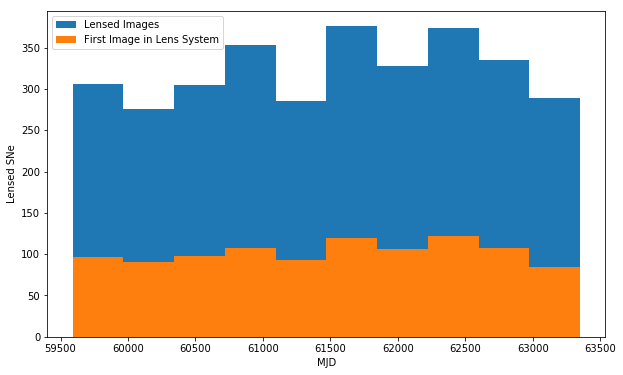

In [47]:
fig = plt.figure(figsize=(10, 6))
n, bins, _ = plt.hist(t_start, label='Lensed Images')
plt.hist(np.unique(keep_catalog['t0']), bins=bins, label='First Image in Lens System')
plt.xlabel('MJD')
plt.ylabel('Lensed SNe')
plt.legend(loc=2)

In [48]:
keep_catalog['t_start'] = t_start

In [49]:
keep_catalog.to_csv('%s_sne_cat.csv' % catalog_version, index=False)

Save the cache of `galaxy_ids` and associated `twinklesId` values to file.

In [50]:
sne_cache = pd.DataFrame(np.array([gal_ids_sn, np.arange(len(keep_systems)) + 1100], dtype=np.int).T, columns=['galtileid', 'twinkles_system'])

In [51]:
sne_cache.to_csv('%s_sne_cache.csv' % catalog_version, index=False)

### Check that `galaxy_ids` will not clash when the sprinkler modifies them

We need to make sure that we can adjust the `galaxy_id` values of the sprinkler galaxies so that we can record information in the id values, but we need to make sure the new id values don't clash with `cosmoDC2` id values. We check that below.

In [52]:
import GCRCatalogs
import pandas as pd
from GCR import GCRQuery

In [53]:
catalog = GCRCatalogs.load_catalog('%s_image_addon_knots' % catalog_version)

In [54]:
cosmo_ids = catalog.get_quantities(['galaxy_id'])

In [55]:
smallest_id = np.min(cosmo_ids['galaxy_id'])
largest_id = np.max(cosmo_ids['galaxy_id'])

In [56]:
print(largest_id, smallest_id)

12083345922 1250000000


The highest `galaxy_id` in `cosmoDC2_v1.1.4_image_addon_knots` is < 1.5e10. Therefore, if we add 1.5e10 to all `galaxy_id` values that are sprinkled then we will be above this. After that we multiply by 10000 to get room to add in the twinkles system numbers in the last 4 digits. If these numbers are less that 2^63 then we will be ok when generating instance catalogs.

In [57]:
offset = np.int(1.5e10)

In [58]:
(2**63) - np.left_shift((largest_id + offset)*10000, 10)

8.9460385746134958e+18

We are under the 2^63 limit. So, we can use this scheme to make sure there are no id clashes and add in the twinkles information as before.